## Setup

In [1]:
import os
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

import numpy as np
import pandas as pd
import random
# import cudf as pd
import tensorflow as tf
import isuelogit as isl
import glob

In [2]:
# Path management
main_dir = str(Path(os.path.abspath('')).parents[1])
os.chdir(main_dir)
print('main dir:', main_dir)

isl.config.dirs['read_network_data'] = "input/network-data/fresno/"

main dir: /Users/pablo/Library/CloudStorage/OneDrive-Personal/data-science/github/gisuelogit


In [3]:
# Internal modules
from src.gisuelogit.models import UtilityParameters, BPRParameters, ODParameters, GISUELOGIT, NGD, compute_rr
from src.gisuelogit.visualizations import plot_predictive_performance, plot_convergence_estimates, plot_top_od_flows_periods, plot_utility_parameters_periods
from src.gisuelogit.networks import load_k_shortest_paths, read_paths, build_fresno_network, \
    Equilibrator, sparsify_OD, ColumnGenerator, read_OD
from src.gisuelogit.etl import get_design_tensor, get_y_tensor, data_curation, temporal_split, add_period_id, get_tensors_by_year
from src.gisuelogit.descriptive_statistics import mse, btcg_mse, mnrmse, nrmse

In [4]:
# Seed for reproducibility
_SEED = 2022
np.random.seed(_SEED)
random.seed(_SEED)
tf.random.set_seed(_SEED)

## Build Fresno network

In [5]:
fresno_network = build_fresno_network()

## Read OD matrix

In [6]:
read_OD(network=fresno_network, sparse=True)

Matrix Q (1789, 1789) read in 0.0[s] with sparse format
66266.3 trips were loaded among 6970 o-d pairs


## Read paths

In [7]:
#read_paths(network=fresno_network, update_incidence_matrices=True, filename='paths-fresno.csv')
read_paths(network=fresno_network, update_incidence_matrices=True, filename = 'paths-full-model-fresno.csv')

# For quick testing
# Q = fresno_network.load_OD(sparsify_OD(fresno_network.Q, prop_od_pairs=0.99))
# load_k_shortest_paths(network=fresno_network, k=2, update_incidence_matrices=True)

18289 paths were read in 35.0[s]              

18289 paths were loaded in the network

Updating incidence matrices

Matrix D (2413, 18289) generated in 32.8[s]               

Matrix M (6970, 18289) generated in 13.4[s]               

Matrix C (18289, 18289) generated in 8.2[s]               



## Read spatiotemporal data

In [68]:
folderpath = isl.config.dirs['read_network_data'] + 'links/spatiotemporal-data/'
df = pd.concat([pd.read_csv(file) for file in glob.glob(folderpath + "*link-data*")], axis=0)

df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
# Select data from Tuesday to Thursday
df = df[df['date'].dt.dayofweek.between(1, 3)]
# df = df[df['date'].dt.year == 2019]

In [ ]:
# Add period id for timevarying estimation

period_feature = 'hour'

df['period'] = df['date'].astype(str) + '-' + df[period_feature].astype(str)
# df['period'] = df.period.map(hash)

df = add_period_id(df, period_feature='hour')

period_keys = df[[period_feature,'period_id']].drop_duplicates()
print(period_keys)

In [71]:
df.head()

,link_key,observed,counts,capacity [veh],tt_ff [min],speed_ff[mi/hr],inrix_id,pems_ids,link_type,id,...,median_age,incidents,bus_stops,intersections,date,hour,tf_inrix,year,period,period_id
0,"(0, 1621, '0')",0,NaN,1800.0,0.098,45,1.626616e+09,[],LWRLK,1,...,31.1,0,0,1,2019-10-01,10,0.221,2019,2019-10-01-10,4
1,"(1239, 1630, '0')",0,NaN,inf,0.000,99999,NaN,[],DMDLK,565,...,0.0,0,0,0,2019-10-01,10,0.000,2019,2019-10-01-10,4
2,"(228, 192, '0')",1,1667.0,2400.0,0.110,65,1.626659e+09,[602350],LWRLK,564,...,16.6,0,0,0,2019-10-01,10,0.112,2019,2019-10-01-10,4
3,"(1243, 1631, '0')",0,NaN,inf,0.000,99999,NaN,[],DMDLK,563,...,0.0,0,0,0,2019-10-01,10,0.000,2019,2019-10-01-10,4
4,"(1244, 1632, '0')",0,NaN,inf,0.000,99999,NaN,[],DMDLK,562,...,0.0,0,0,0,2019-10-01,10,0.000,2019,2019-10-01-10,4


## Data curation

In [72]:
df['tt_ff'] = np.where(df['link_type'] != 'LWRLK', 0,df['length']/df['speed_ref_avg'])
df.loc[(df.link_type == "LWRLK") & (df.speed_ref_avg == 0),'tt_ff'] = float('nan')

df['tt_avg'] = np.where(df['link_type'] != 'LWRLK', 0,df['length']/df['speed_hist_avg'])
df.loc[(df.link_type == "LWRLK") & (df.speed_hist_avg == 0),'tt_avg'] = float('nan')

df = data_curation(df)

## Utility function

In [73]:
# features_Z = ['speed_sd', 'median_inc', 'incidents', 'bus_stops', 'intersections']
features_Z = ['tt_sd', 'median_inc', 'incidents', 'bus_stops', 'intersections']

utility_parameters = UtilityParameters(features_Y=['tt'],
                                       features_Z=features_Z,
                                       initial_values={'tt': 0, 'c': 0, 's': 0, 'psc_factor': 0,
                                                       'fixed_effect': np.zeros_like(fresno_network.links)},
                                       signs={'tt': '-', 'tt_sd': '-', 'median_inc': '+', 'incidents': '-',
                                              'bus_stops': '-', 'intersections': '-'},
                                       trainables={'psc_factor': False, 'fixed_effect': False},
                                       )

utility_parameters.constant_initializer(0)

## Data processing

In [74]:
n_links = len(fresno_network.links)
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df['year'] = df.date.dt.year
X, Y = {}, {}

In [75]:
df.query('year == 2019')[['counts', 'tt_ff', 'tt_avg', 'tf_inrix', 'tt_sd']].describe()

,counts,tt_ff,tt_avg,tf_inrix,tt_sd
count,31624.000000,542925.000000,468303.000000,542925.000000,542925.000000
mean,1761.140959,0.003416,0.003699,0.200169,0.046165
std,770.228931,0.004372,0.004448,0.228208,0.087692
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,1249.000000,0.000000,0.000000,0.000000,0.000000
50%,1686.000000,0.002508,0.002814,0.152000,0.010000
75%,2162.450000,0.004704,0.005304,0.280000,0.057000
max,4807.000000,0.070407,0.063791,2.302000,3.721000


In [76]:
df.query('year == 2020')[['counts', 'tt_ff', 'tt_avg', 'tf_inrix', 'tt_sd']].describe()

,counts,tt_ff,tt_avg,tf_inrix,tt_sd
count,19585.000000,335407.000000,299058.000000,335407.000000,335407.000000
mean,1610.617176,0.003377,0.003618,0.198506,0.024397
std,749.986396,0.004328,0.004283,0.226039,0.040677
min,6.000000,0.000000,0.000000,0.000000,0.000000
25%,1110.000000,0.000000,0.000000,0.000000,0.000000
50%,1533.000000,0.002491,0.002759,0.150000,0.010000
75%,1988.000000,0.004578,0.005121,0.273000,0.033000
max,4766.000000,0.070407,0.054574,3.203000,1.244000


In [77]:
# Set free flow travel times
tt_ff_links = df.groupby('link_key')['tt_ff'].min()
for link in fresno_network.links:
    fresno_network.links_dict[link.key].performance_function.tf = float(tt_ff_links[tt_ff_links.index==str(link.key)])

In [78]:
# Select only dates used for previous paper

# df = df.query('date == "2019-10-01"  | date == "2020-10-06"')
# df = df.query('date == "2019-10-01"')
# df = df.query('hour == 16')
# df = df.query('hour == 17')
#df = df.query('hour == 16 | hour == 17')

## EDA

In [79]:
df.describe()

/Users/pablo/Library/Caches/pypoetry/virtualenvs/aesuelogit-1kW0OCrg-py3.9/lib/python3.9/site-packages/numpy/lib/function_base.py:4009: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


,observed,counts,capacity [veh],tt_ff [min],speed_ff[mi/hr],inrix_id,id,rhoj,lane,ff_speed,...,median_inc,median_age,incidents,bus_stops,intersections,hour,tf_inrix,year,period_id,tt_ff
count,878332.000000,51209.000000,878332.0,878332.000000,878332.000000,5.343520e+05,878332.000000,878332.000000,878332.000000,878332.000000,...,878332.000000,878332.000000,878332.000000,878332.000000,878332.000000,878332.000000,878332.000000,878332.000000,878332.000000,878332.000000
mean,0.058365,1703.572792,inf,0.150823,28872.664318,9.131292e+08,1655.934107,28984.643183,1.928305,28872.664318,...,26.219132,22.575946,0.729798,0.150021,0.876502,13.043956,0.199534,2019.381868,7.043956,0.003401
std,0.234433,766.044106,NaN,0.172422,45284.561416,6.017163e+08,1171.319358,45213.266003,1.086900,45284.561416,...,21.357385,15.623136,3.176771,0.441193,1.319496,4.318152,0.227384,0.485845,4.318152,0.004355
min,0.000000,1.000000,1800.0,0.000000,15.000000,1.685461e+08,1.000000,180.000000,1.000000,15.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,0.000000,2019.000000,0.000000,0.000000
25%,0.000000,1190.500000,1800.0,0.000000,40.000000,4.416712e+08,604.000000,200.000000,1.000000,40.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,0.000000,2019.000000,3.000000,0.000000
50%,0.000000,1626.000000,1800.0,0.121000,45.000000,4.498919e+08,1628.000000,200.000000,2.000000,45.000000,...,24.821000,27.800000,0.000000,0.000000,0.000000,13.000000,0.151000,2019.000000,7.000000,0.002496
75%,0.000000,2103.500000,NaN,0.205000,99999.000000,1.626675e+09,2596.000000,99999.000000,3.000000,99999.000000,...,41.681000,33.100000,0.000000,0.000000,1.000000,17.000000,0.277000,2020.000000,11.000000,0.004667
max,1.000000,4807.000000,inf,2.113000,99999.000000,1.626774e+09,4387.000000,99999.000000,6.000000,99999.000000,...,115.893000,66.000000,40.000000,4.000000,9.000000,20.000000,3.203000,2020.000000,14.000000,0.070407


In [80]:
# To check that there is a balanced amount of observations per date
obs_date = df.groupby('date')['hour'].count()

In [81]:
# Stats by date
df.groupby('date')[['speed_sd','speed_avg', 'counts']].mean().assign(total_obs = obs_date)

,speed_sd,speed_avg,counts,total_obs
date,,,,
2019-10-01,1.731787,17.175187,1770.335035,36195
2019-10-02,1.760109,17.169768,1746.651824,36195
2019-10-03,1.754288,17.092304,1785.115209,36195
2019-10-08,1.847060,18.165569,1747.732955,36195
2019-10-09,1.917923,18.137042,1756.834846,36195
2019-10-10,1.830232,18.107925,1793.512340,36195
2019-10-15,1.831527,18.114384,1750.339155,36195
2019-10-16,1.823680,18.162625,1760.170975,36195
2019-10-17,1.832219,18.080860,1775.411385,36195


### Cross sectional

In [82]:
eda_df = df.copy()
eda_df['date'] = eda_df['date'].astype(str)

# Transform to monthly income
eda_df['median_inc'] = eda_df['median_inc']/12

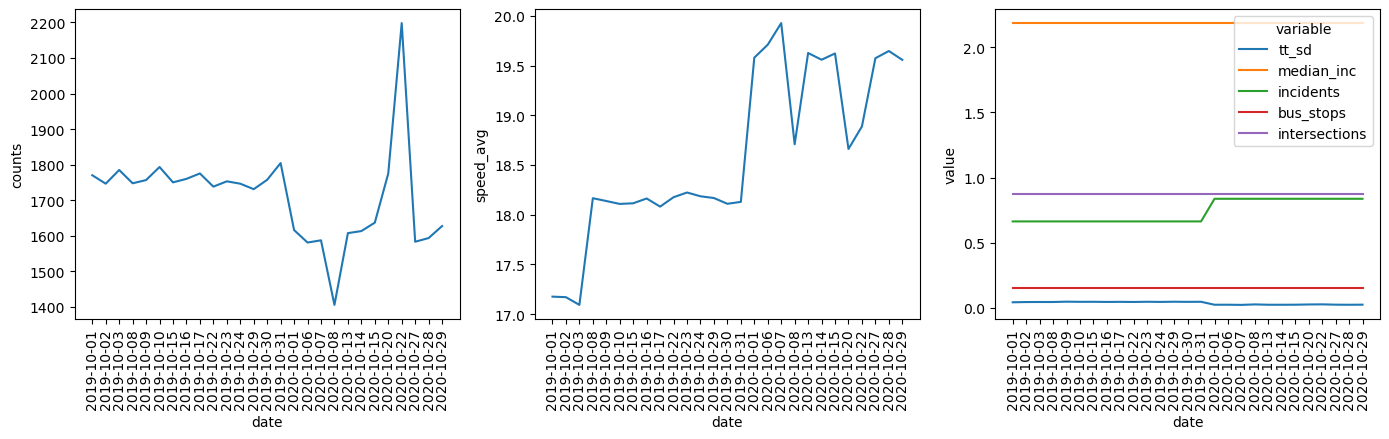

In [141]:
fig, axs = plt.subplots(1,3, figsize = (14,4.5))

sns.lineplot(x= 'date', y = 'counts', data =eda_df.groupby('date')[['counts']].mean().reset_index(),
             ax = axs[0])

sns.lineplot(x= 'date', y = 'speed_avg', data =eda_df.groupby('date')[['speed_avg']].mean().reset_index(),
             ax = axs[1])

sns.lineplot(x= 'date', y = 'value', hue = 'variable', data =pd.melt(eda_df.groupby('date')[features_Z].mean().reset_index(),id_vars= ['date']),
             ax = axs[2])

#list(map(lambda x: x.set_xticklabels(x.get_xticks(), rotation=90), axs));
fig.autofmt_xdate(rotation = 90, ha = 'center')
fig.tight_layout()

### By hour of day

In [86]:
link_keys = eda_df[(eda_df.counts>0) & (eda_df.speed_avg>0)].link_key.unique()
link_keys = link_keys[0:10]

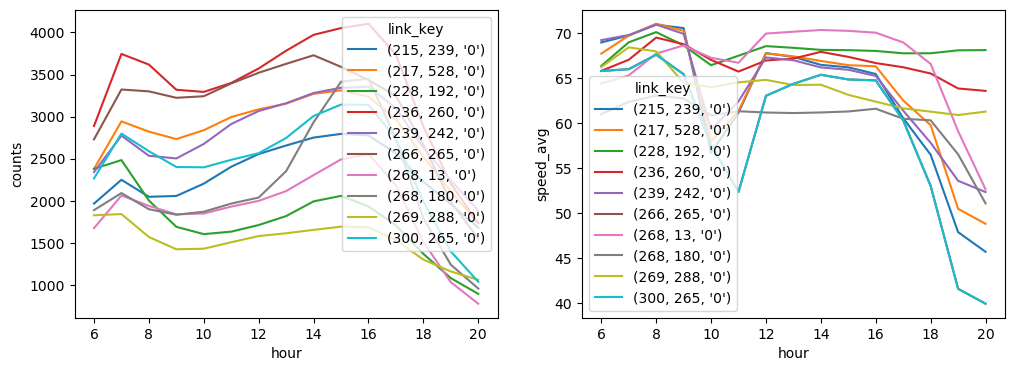

In [137]:
fig, axs = plt.subplots(1,2, figsize = (8,4))

sns.lineplot(x= 'hour', y = 'counts', hue = 'link_key',
             data =eda_df[eda_df.link_key.isin(link_keys)].groupby(['hour','link_key'])[['counts']].mean().reset_index(),
             ax = axs[0])

sns.lineplot(x= 'hour', y = 'speed_avg', hue = 'link_key',
             data =eda_df[eda_df.link_key.isin(link_keys)].groupby(['hour','link_key'])[['speed_avg']].mean().reset_index(),
             ax = axs[1])

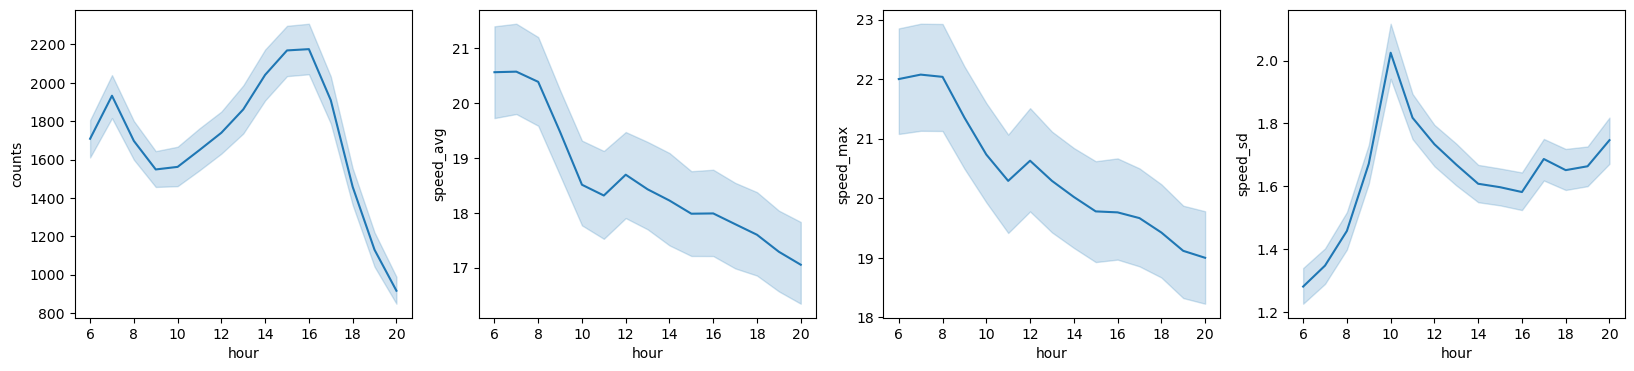

In [135]:
fig, axs = plt.subplots(1,4, figsize = (20,4))

sns.lineplot(x= 'hour', y = 'counts', data =eda_df.groupby(['hour','link_key'])[['counts']].mean().reset_index(),
             ax = axs[0])

sns.lineplot(x= 'hour', y = 'speed_avg',
             data =eda_df.groupby(['hour','link_key'])[['speed_avg']].mean().reset_index(),
             ax = axs[1])

sns.lineplot(x= 'hour', y = 'speed_max',
             data =eda_df.groupby(['hour','link_key'])[['speed_max']].mean().reset_index(),
             ax = axs[2])

sns.lineplot(x= 'hour', y = 'speed_sd',
             data =eda_df.groupby(['hour','link_key'])[['speed_sd']].mean().reset_index(),
             ax = axs[3])

## Training and validation sets

In [143]:
# Include only data between 4pm and 5pm
X, Y = get_tensors_by_year(df[df.hour == 16], features_Z = features_Z)
# Include hourly data between 6AM and 8PM (15 hour intervals)
XT, YT = get_tensors_by_year(df, features_Z = features_Z)

# X_train, X_test, Y_train, Y_test = temporal_split(X[2019].numpy(), Y[2019].numpy(), n_days = X[2019].shape[0])

# X_train, X_test, Y_train, Y_test = X[2020], X[2019], Y[2020], Y[2019]
X_train, X_test, Y_train, Y_test = X[2019], X[2020], Y[2019], Y[2020]
XT_train, XT_test, YT_train, YT_test = XT[2019], XT[2020], YT[2019], YT[2020]

# Remove validation set to reduce computation costs
X_test, Y_test = None, None
XT_test, YT_test = None, None

## Network equilibrium predictor

In [144]:
equilibrator = Equilibrator(
    network=fresno_network,
    # paths_generator=paths_generator,
    utility=utility_parameters,
    max_iters=100,
    method='fw',
    iters_fw=50,
    accuracy=1e-4,
)

column_generator = ColumnGenerator(equilibrator=equilibrator,
                                   utility=utility_parameters,
                                   n_paths=0,
                                   ods_coverage=0.1,
                                   ods_sampling='sequential',
                                   # ods_sampling='demand',
                                   )

## Configuration

In [145]:
# _EPOCHS = {'learning': 6, 'equilibrium': 10}
_EPOCHS = {'learning': 100, 'equilibrium': 10}
_EPOCHS = {'learning': 250, 'equilibrium': 50}
_BATCH_SIZE = 16
_LR = 5e-1
_RELATIVE_GAP = 1e-5
_XTICKS_SPACING = 50
_EPOCHS_PRINT_INTERVAL = 1

# Excluding historic OD gives more freedom for the model to find an equilibria and minimize reconstruction error
_LOSS_WEIGHTS ={'od': 0, 'tt': 1, 'flow': 1, 'eq_flow': 1}

# _LOSS_METRIC  = mnrmse
# _MOMENTUM_EQUILIBRIUM = {'lue': 0.95, 'odlue': 0.95, 'odlulpe-1': 0.95, 'odlulpe-2': 0.95}

# NRMSE encourages a larger reduction in link flow loss and it does not requires to add much momentum to the equilibrium loss component
_LOSS_METRIC  = nrmse
_MOMENTUM_EQUILIBRIUM = {'lue': 0.99, 'odlue': 0.99, 'odlulpe-1': 0.99, 'odlulpe-2': 0.99,
                         'tvodlulpe':0.99}

# Including historic OD matrix
# _LOSS_WEIGHTS ={'od': 1, 'tt': 1, 'flow': 1, 'eq_flow': 1}
# _MOMENTUM_EQUILIBRIUM = 0.99

# _LOSS_METRIC = mse
# _LOSS_WEIGHTS ={'od': 1, 'theta': 0, 'tt': 1e10, 'flow': 1, 'eq_flow': 1}

print(f"_LOSS_WEIGHTS: {_LOSS_WEIGHTS}, _MOMENTUM_EQUILIBRIUM: {_MOMENTUM_EQUILIBRIUM}, "
      f"epochs { _EPOCHS}")

_LOSS_WEIGHTS: {'od': 0, 'tt': 1, 'flow': 1, 'eq_flow': 1}, _MOMENTUM_EQUILIBRIUM: {'lue': 0.99, 'odlue': 0.99, 'odlulpe-1': 0.99, 'odlulpe-2': 0.99, 'tvodlulpe': 0.99}, epochs {'learning': 250, 'equilibrium': 50}


## Models

In [149]:
run_model = dict.fromkeys(['equilibrium', 'lue', 'ode', 'odlue', 'odlulpe-1','odlulpe-2', 'tvodlulpe'], True)

# run_model['lue'] = True
# run_model['ode'] = True
# run_model['odlue'] = True
# run_model['odlulpe-1'] = True
# run_model['odlulpe-2'] = True
# run_model['tvodlulpe'] = True

In [147]:
train_results_dfs = {}
test_results_dfs = {}

### Model 2: Benchmark of gisuelogit and isuelogit

In [150]:
if run_model['lue']:
    print('\nLUE: Benchmark of gisuelogit and isuelogit (utility only)')

    # _MOMENTUM_EQUILIBRIUM = 1

    optimizer = tf.keras.optimizers.Adam(learning_rate=_LR)

    utility_parameters = UtilityParameters(features_Y=['tt'],
                                           features_Z=features_Z,
                                           # initial_values ={'tt': -1, 'tt_sd': -1, 'median_inc': 1,
                                           #                  'incidents': -1, 'bus_stops': -1, 'intersections': -1,
                                           #                  'psc_factor': 0, 'fixed_effect': np.zeros_like(fresno_network.links)},
                                           initial_values={'psc_factor': 0,
                                                           'fixed_effect': np.zeros_like(fresno_network.links)},
                                           signs={'tt': '-', 'tt_sd': '-', 'median_inc': '+', 'incidents': '-',
                                                  'bus_stops': '-', 'intersections': '-'},
                                           trainables={'psc_factor': False, 'fixed_effect': True,
                                                       'tt': True, 'tt_sd': True, 'median_inc': True, 'incidents': True,
                                                              'bus_stops': True, 'intersections': True
                                                       },
                                           )

    utility_parameters.constant_initializer(0)

    bpr_parameters = BPRParameters(keys=['alpha', 'beta'],
                                   initial_values={'alpha': 0.15, 'beta': 4},
                                   trainables=dict.fromkeys(['alpha', 'beta'], False),
                                   )

    od_parameters = ODParameters(key='od',
                                 initial_values=fresno_network.q.flatten(),
                                 true_values=fresno_network.q.flatten(),
                                 historic_values={1: fresno_network.q.flatten()},
                                 trainable=False)

    equilibrator = Equilibrator(
        network=fresno_network,
        utility=utility_parameters,
        max_iters=100,
        method='fw',
        iters_fw=50,
        accuracy=1e-4,
    )

    column_generator = ColumnGenerator(equilibrator=equilibrator,
                                       utility=utility_parameters,
                                       n_paths=0,
                                       ods_coverage=0.1,
                                       ods_sampling='sequential',
                                       )

    lue = GISUELOGIT(
        key='lue',
        network=fresno_network,
        dtype=tf.float64,
        equilibrator = equilibrator,
        utility=utility_parameters,
        bpr=bpr_parameters,
        od=od_parameters
    )

    train_results_dfs['lue'], test_results_dfs['lue'] = lue.train(
        X_train, Y_train, X_test, Y_test,
        optimizer=optimizer,
        batch_size=_BATCH_SIZE,
        threshold_relative_gap=_RELATIVE_GAP,
        momentum_equilibrium = _MOMENTUM_EQUILIBRIUM['lue'],
        loss_weights= dict(_LOSS_WEIGHTS, od = 0),
        loss_metric=_LOSS_METRIC,
        epochs_print_interval=_EPOCHS_PRINT_INTERVAL,
        epochs=_EPOCHS)

    sns.displot(pd.DataFrame({'fixed_effect':np.array(lue.fixed_effect)}),
            x="fixed_effect", multiple="stack", kind="kde", alpha = 0.8)

    plot_predictive_performance(train_losses=train_results_dfs['lue'], val_losses=test_results_dfs['lue'],
                                xticks_spacing = _XTICKS_SPACING)


    print(f"theta = {dict(zip(utility_parameters.true_values.keys(), list(lue.theta.numpy())))}")
    print(f"alpha = {lue.alpha: 0.2f}, beta  = {lue.beta: 0.2f}")
    print(f"Avg abs diff of observed and estimated OD: {np.mean(np.abs(lue.q - fresno_network.q.flatten())): 0.2f}")
    print(f"Avg observed OD: {np.mean(np.abs(fresno_network.q.flatten())): 0.2f}")


LUE: Benchmark of gisuelogit and isuelogit (utility only)

Epoch: 0/250, n_periods: 1,  n_train: 225
0: train_loss=2.3e+06, val_loss=0, train_loss tt=3.9e-05, val_loss tt=0, train_loss flow=2.3e+06, val_loss flow=0, theta = [0. 0. 0. 0. 0. 0.], avg rr = nan, psc_factor = 0.0, avg theta fixed effect = 0, avg alpha=0.15, avg beta=4, loss demand=3.2e-29, lambda eq=1, relative x=6.5e-16, relative gap=1e-05, train flow equilibrium loss=1.4e-24, time: 101.2


KeyboardInterrupt: 

### Model 3: OD + utility estimation with historic OD

In [37]:
if run_model['odlue']:

    # _MOMENTUM_EQUILIBRIUM = 0.99

    print('\nODLUE: OD + utility estimation with historic OD')

    # _RELATIVE_GAP = 1e-4\
    # _XTICKS_SPACING = 50

    optimizer = tf.keras.optimizers.Adam(learning_rate=_LR)
    # optimizer = tf.keras.optimizers.Adagrad(learning_rate=_LR)
    utility_parameters = UtilityParameters(features_Y=['tt'],
                                           features_Z=features_Z,
                                           initial_values={'psc_factor': 0,
                                                           'fixed_effect': np.zeros_like(fresno_network.links)},
                                           signs={'tt': '-', 'tt_sd': '-', 'median_inc': '+', 'incidents': '-',
                                                  'bus_stops': '-', 'intersections': '-'},
                                           trainables={'psc_factor': False, 'fixed_effect': True,
                                                       'tt': True, 'tt_sd': True, 'median_inc': True,
                                                       'incidents': True,
                                                       'bus_stops': True, 'intersections': True
                                                       },
                                           )

    bpr_parameters = BPRParameters(keys=['alpha', 'beta'],
                                   initial_values={'alpha': 0.15, 'beta': 4},
                                   trainables=dict.fromkeys(['alpha', 'beta'], False),
                                   )

    od_parameters = ODParameters(key='od',
                                 initial_values=fresno_network.q.flatten(),
                                 historic_values={1: fresno_network.q.flatten()},
                                 trainable=True)

    equilibrator = Equilibrator(
        network=fresno_network,
        # paths_generator=paths_generator,
        utility=utility_parameters,
        max_iters=100,
        method='fw',
        iters_fw=50,
        accuracy=1e-4,
    )

    column_generator = ColumnGenerator(equilibrator=equilibrator,
                                       utility=utility_parameters,
                                       n_paths=0,
                                       ods_coverage=0.1,
                                       ods_sampling='sequential',
                                       # ods_sampling='demand',
                                       )

    odlue = GISUELOGIT(
        key='odlue',
        network=fresno_network,
        dtype=tf.float64,
        equilibrator=equilibrator,
        column_generator=column_generator,
        utility=utility_parameters,
        bpr=bpr_parameters,
        od=od_parameters,
    )

    train_results_dfs['odlue'], test_results_dfs['odlue'] = odlue.train(
        X_train, Y_train, X_test, Y_test,
        optimizer=optimizer,
        batch_size=_BATCH_SIZE,
        # generalization_error={'train': False, 'validation': True},
        loss_weights= _LOSS_WEIGHTS,
        loss_metric=_LOSS_METRIC,
        momentum_equilibrium = _MOMENTUM_EQUILIBRIUM['odlue'],
        threshold_relative_gap=_RELATIVE_GAP,
        epochs_print_interval=_EPOCHS_PRINT_INTERVAL,
        epochs=_EPOCHS)

    plot_predictive_performance(train_losses=train_results_dfs['odlue'], val_losses=test_results_dfs['odlue'],
                                xticks_spacing = _XTICKS_SPACING)

    plot_convergence_estimates(estimates=train_results_dfs['odlue'].\
                           assign(rr = train_results_dfs['odlue']['tt_sd']/train_results_dfs['odlue']['tt'])[['epoch','rr']],
                               xticks_spacing = _XTICKS_SPACING)

    sns.displot(pd.DataFrame({'fixed_effect':np.array(odlue.fixed_effect)}),
            x="fixed_effect", multiple="stack", kind="kde", alpha = 0.8)

    print(f"theta = {dict(zip(utility_parameters.true_values.keys(), list(odlue.theta.numpy())))}")
    print(f"alpha = {odlue.alpha: 0.2f}, beta  = {odlue.beta: 0.2f}")
    print(f"Avg abs diff of observed and estimated OD: {np.mean(np.abs(odlue.q - fresno_network.q.flatten())): 0.2f}")
    print(f"Avg observed OD: {np.mean(np.abs(fresno_network.q.flatten())): 0.2f}")

### Model 4: ODLUE + link specific performance parameters (only alphas)


ODLULPE: ODLUE + link performance parameters with historic OD matrix (link specifics alpha)

Epoch: 0/250, n_periods: 1,  n_train: 140
0: train_loss=2.3e+06, val_loss=0, train_loss tt=3.9e-05, val_loss tt=0, train_loss flow=2.3e+06, val_loss flow=0, theta = [0. 0. 0. 0. 0. 0.], avg rr = nan, psc_factor = 0.0, avg theta fixed effect = 0, avg alpha=0.15, avg beta=4, loss demand=3.2e-29, lambda eq=1, relative x=4.4e-16, relative gap=1e-05, train flow equilibrium loss=6.4e-25, time: 76.0

Epoch: 1/250, n_periods: 1,  n_train: 140
1: train_loss=7.2e+05, val_loss=0, train_loss tt=1.9e-05, val_loss tt=0, train_loss flow=2e+06, val_loss flow=0, theta = [-2.536 -3.095  0.    -2.153 -3.724 -2.907], avg rr = 1.22, psc_factor = 0.0, avg theta fixed effect = -0.091, avg alpha=0.58, avg beta=4, loss demand=1.1e+02, lambda eq=0.34, relative x=0.26, relative gap=74, train flow equilibrium loss=1.5e+05, time: 196.3

Epoch: 2/250, n_periods: 1,  n_train: 140
2: train_loss=6.1e+05, val_loss=0, train_los

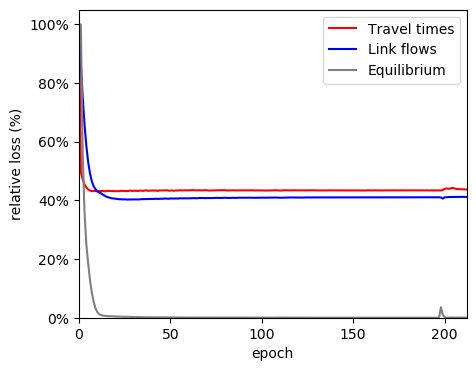

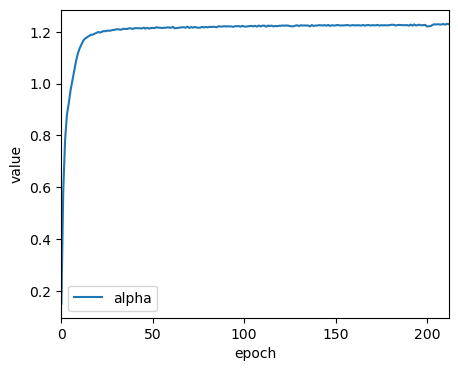

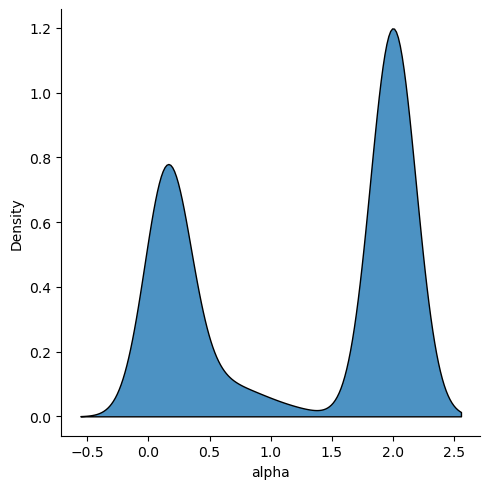

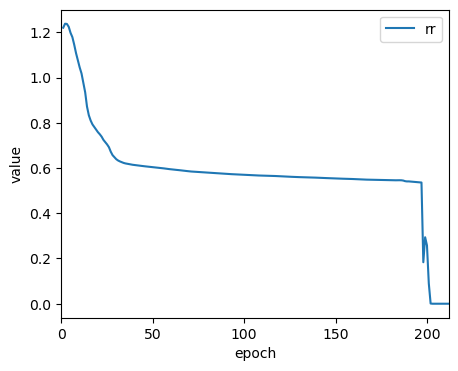

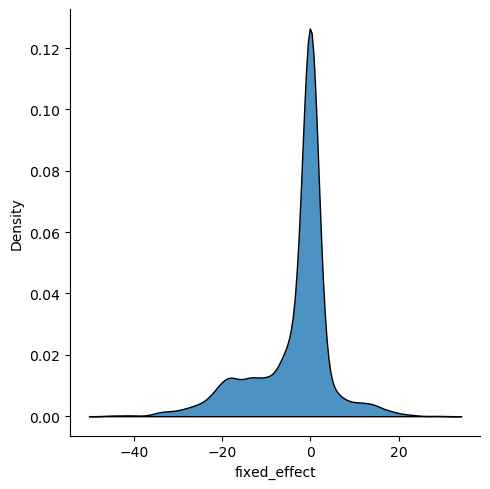

In [46]:
if run_model['odlulpe-1']:

    print('\nODLULPE: ODLUE + link performance parameters with historic OD matrix (link specifics alpha)')

    # _MOMENTUM_EQUILIBRIUM = 0.99

    optimizer = tf.keras.optimizers.Adam(learning_rate=_LR)

    # _LR = 1e-2
    # _RELATIVE_GAP = 1e-5
    # _XTICKS_SPACING = 50

    # Some initializations of the bpr parameters, makes the optimization to fail (e.g. alpha =1, beta = 1). Using a common
    # alpha but different betas for every link make the estimation more stable but there is overfitting after a certain amount of iterations

    bpr_parameters = BPRParameters(keys=['alpha', 'beta'],
                                   # initial_values={'alpha': 0.15*np.ones_like(fresno_network.links,dtype = np.float32),
                                   #                 'beta': 4*np.ones_like(fresno_network.links,dtype = np.float32)},
                                   initial_values={'alpha': 0.15*np.ones_like(fresno_network.links,dtype = np.float32),
                                                   'beta': 4},
                                   # initial_values={'alpha': 0.15, 'beta': 4},
                                   # initial_values={'alpha': 0.15,
                                   #                 'beta': 4 * np.ones_like(fresno_network.links, dtype=np.float32)},
                                   # initial_values={'alpha': 0.15, 'beta': 4},
                                   trainables={'alpha': True, 'beta':False},
                                   # trainables={'alpha': True, 'beta': True},
                                   # trainables={'alpha': False, 'beta': True},
                                   )

    od_parameters = ODParameters(key='od',
                                 initial_values=fresno_network.q.flatten(),
                                 historic_values={1: fresno_network.q.flatten()},
                                 trainable=True)

    utility_parameters = UtilityParameters(features_Y=['tt'],
                                           features_Z=features_Z,
                                           initial_values={'psc_factor': 0, 'tt':0,
                                                           'fixed_effect': np.zeros_like(fresno_network.links)},
                                           signs={'tt': '-', 'tt_sd': '-', 'median_inc': '+', 'incidents': '-',
                                                  'bus_stops': '-', 'intersections': '-'},
                                           trainables={'psc_factor': False, 'fixed_effect': True,
                                                       'tt': True, 'tt_sd': True, 'median_inc': True,
                                                       'incidents': True,
                                                       'bus_stops': True, 'intersections': True
                                                       },
                                           )

    equilibrator = Equilibrator(
        network=fresno_network,
        # paths_generator=paths_generator,
        utility=utility_parameters,
        max_iters=100,
        method='fw',
        iters_fw=50,
        accuracy=1e-4,
    )

    column_generator = ColumnGenerator(equilibrator=equilibrator,
                                       utility=utility_parameters,
                                       n_paths=0,
                                       ods_coverage=0.1,
                                       ods_sampling='sequential',
                                       # ods_sampling='demand',
                                       )

    odlulpe_1 = GISUELOGIT(
        key='odlulpe-1',
        network=fresno_network,
        dtype=tf.float64,
        equilibrator=equilibrator,
        column_generator=column_generator,
        utility=utility_parameters,
        bpr=bpr_parameters,
        od=od_parameters,
    )

    train_results_dfs['odlulpe-1'], test_results_dfs['odlulpe-1'] = odlulpe_1.train(
        X_train, Y_train, X_test, Y_test,
        optimizer=optimizer,
        # generalization_error={'train': False, 'validation': True},
        batch_size=_BATCH_SIZE,
        loss_weights=_LOSS_WEIGHTS,
        loss_metric=_LOSS_METRIC,
        momentum_equilibrium = _MOMENTUM_EQUILIBRIUM['odlulpe-1'],
        threshold_relative_gap=_RELATIVE_GAP,
        epochs_print_interval=_EPOCHS_PRINT_INTERVAL,
        epochs=_EPOCHS)

    plot_predictive_performance(train_losses=train_results_dfs['odlulpe-1'], val_losses=test_results_dfs['odlulpe-1'],
                                xticks_spacing = _XTICKS_SPACING)

    plot_convergence_estimates(estimates=train_results_dfs['odlulpe-1'][['epoch','alpha']],
                                xticks_spacing = _XTICKS_SPACING)

    sns.displot(pd.DataFrame({'alpha':odlulpe_1.alpha}),
            x="alpha", multiple="stack", kind="kde", alpha = 0.8)

    plot_convergence_estimates(estimates=train_results_dfs['odlulpe-1'].\
                       assign(rr = train_results_dfs['odlulpe-1']['tt_sd']/train_results_dfs['odlulpe-1']['tt'])[['epoch','rr']],
                           xticks_spacing = _XTICKS_SPACING)


    sns.displot(pd.DataFrame({'fixed_effect':np.array(odlulpe_1.fixed_effect)}),
                x="fixed_effect", multiple="stack", kind="kde", alpha = 0.8)

    print(f"theta = {dict(zip(utility_parameters.true_values.keys(), list(odlulpe_1.theta.numpy())))}")
    print(f"alpha = {np.mean(odlulpe_1.alpha): 0.2f}, beta  = {np.mean(odlulpe_1.beta): 0.2f}")
    print(f"Avg abs diff of observed and estimated OD: {np.mean(np.abs(odlulpe_1.q - fresno_network.q.flatten())): 0.2f}")
    print(f"Avg observed OD: {np.mean(np.abs(fresno_network.q.flatten())): 0.2f}")

### Model 5: ODLUE + link specific performance parameters (alphas and betas)

In [39]:
if run_model['odlulpe-2']:

    print('\nODLULPE: ODLUE + link performance parameters with historic OD matrix (link specifics alphas and betas)')

    # _MOMENTUM_EQUILIBRIUM = 0.99

    optimizer = tf.keras.optimizers.Adam(learning_rate=_LR)

    # _LR = 5e-1
    # _RELATIVE_GAP = 1e-5

    # Some initializations of the bpr parameters, makes the optimization to fail (e.g. alpha =1, beta = 1). Using a common
    # alpha but different betas for every link make the estimation more stable but there is overfitting after a certain amount of iterations

    bpr_parameters = BPRParameters(keys=['alpha', 'beta'],
                                   initial_values={'alpha': 0.15*np.ones_like(fresno_network.links,dtype = np.float32),
                                                   'beta': 4*np.ones_like(fresno_network.links,dtype = np.float32)},
                                   # initial_values={'alpha': 0.15*np.ones_like(fresno_network.links,dtype = np.float32),
                                   #                 'beta': 4},
                                   # initial_values={'alpha': 0.15, 'beta': 4},
                                   # initial_values={'alpha': 0.15,
                                   #                 'beta': 4 * np.ones_like(fresno_network.links, dtype=np.float32)},
                                   # initial_values={'alpha': 0.15, 'beta': 4},
                                   # trainables={'alpha': True, 'beta':False},
                                   trainables={'alpha': True, 'beta': True},
                                   # trainables={'alpha': False, 'beta': True},
                                   )

    od_parameters = ODParameters(key='od',
                                 initial_values=fresno_network.q.flatten(),
                                 historic_values={1: fresno_network.q.flatten()},
                                 trainable=True)

    utility_parameters = UtilityParameters(features_Y=['tt'],
                                           features_Z=features_Z,
                                           initial_values={'psc_factor': 0, 'tt':0,
                                                           'fixed_effect': np.zeros_like(fresno_network.links)},
                                           signs={'tt': '-', 'tt_sd': '-', 'median_inc': '+', 'incidents': '-',
                                                  'bus_stops': '-', 'intersections': '-'},
                                           trainables={'psc_factor': False, 'fixed_effect': True,
                                                       'tt': True, 'tt_sd': True, 'median_inc': True,
                                                       'incidents': True,
                                                       'bus_stops': True, 'intersections': True
                                                       },
                                           )

    equilibrator = Equilibrator(
        network=fresno_network,
        # paths_generator=paths_generator,
        utility=utility_parameters,
        max_iters=100,
        method='fw',
        iters_fw=50,
        accuracy=1e-4,
    )

    column_generator = ColumnGenerator(equilibrator=equilibrator,
                                       utility=utility_parameters,
                                       n_paths=0,
                                       ods_coverage=0.1,
                                       ods_sampling='sequential',
                                       # ods_sampling='demand',
                                       )

    odlulpe_2 = GISUELOGIT(
        key='odlulpe-2',
        network=fresno_network,
        dtype=tf.float64,
        equilibrator=equilibrator,
        column_generator=column_generator,
        utility=utility_parameters,
        bpr=bpr_parameters,
        od=od_parameters,
    )

    train_results_dfs['odlulpe-2'], test_results_dfs['odlulpe-2'] = odlulpe_2.train(
        X_train, Y_train, X_test, Y_test,
        optimizer=optimizer,
        # generalization_error={'train': False, 'validation': True},
        batch_size=_BATCH_SIZE,
        # loss_weights={'od': 1, 'theta': 0, 'tt': 1, 'flow': 1, 'eq_flow': 1},
        loss_weights=_LOSS_WEIGHTS,
        momentum_equilibrium = _MOMENTUM_EQUILIBRIUM['odlulpe-2'],
        threshold_relative_gap=_RELATIVE_GAP,
        epochs_print_interval=_EPOCHS_PRINT_INTERVAL,
        loss_metric=_LOSS_METRIC,
        epochs=_EPOCHS)

    plot_predictive_performance(train_losses=train_results_dfs['odlulpe-2'], val_losses=test_results_dfs['odlulpe-2'],
                                xticks_spacing = _XTICKS_SPACING)

    plot_convergence_estimates(estimates=train_results_dfs['odlulpe-2'][['epoch','alpha','beta']],
                                xticks_spacing = _XTICKS_SPACING)

    sns.displot(pd.melt(pd.DataFrame({'alpha':odlulpe_2.alpha, 'beta': odlulpe_2.beta}), var_name = 'parameters'),
                x="value", hue="parameters", multiple="stack", kind="kde", alpha = 0.8)

    plot_convergence_estimates(estimates=train_results_dfs['odlulpe-2'].\
                       assign(rr = train_results_dfs['odlulpe-2']['tt_sd']/train_results_dfs['odlulpe-2']['tt'])[['epoch','rr']],
                           xticks_spacing = _XTICKS_SPACING)

    sns.displot(pd.DataFrame({'fixed_effect':np.array(odlulpe_2.fixed_effect)}),
                x="fixed_effect", multiple="stack", kind="kde", alpha = 0.8)

    print(f"theta = {dict(zip(utility_parameters.true_values.keys(), list(odlulpe_2.theta.numpy())))}")
    print(f"alpha = {np.mean(odlulpe_2.alpha): 0.2f}, beta  = {np.mean(odlulpe_2.beta): 0.2f}")
    print(f"Avg abs diff of observed and estimated OD: {np.mean(np.abs(odlulpe_2.q - fresno_network.q.flatten())): 0.2f}")
    print(f"Avg observed OD: {np.mean(np.abs(fresno_network.q.flatten())): 0.2f}")

### Model 6: TVODLULPE (ODLULPE with Time Varying OD and Utility Function)

In [47]:
if run_model['tvodlulpe']:
    print('\ntvodlulpe: Time specific utility and OD, link performance parameters, no historic OD')

    optimizer = tf.keras.optimizers.Adam(learning_rate=_LR)

    utility_parameters = UtilityParameters(features_Y=['tt'],
                                           features_Z=features_Z,
                                           initial_values={'tt': 0, 'tt_sd': 0, 's': 0, 'psc_factor': 0,
                                                           'fixed_effect': np.zeros_like(fresno_network.links)},
                                           signs={'tt': '-', 'tt_sd': '-', 'median_inc': '+', 'incidents': '-',
                                                  'bus_stops': '-', 'intersections': '-'},
                                           trainables={'psc_factor': False, 'fixed_effect': True},
                                           )

    bpr_parameters = BPRParameters(keys=['alpha', 'beta'],
                                   initial_values={'alpha': 0.15*np.ones_like(fresno_network.links,dtype = np.float32),
                                                   'beta': 4*np.ones_like(fresno_network.links,dtype = np.float32)},
                                   trainables={'alpha': True, 'beta': True},
                                   )

    od_parameters = ODParameters(key='od',
                                 initial_values=fresno_network.q.flatten(),
                                 true_values=fresno_network.q.flatten(),
                                 historic_values={1: fresno_network.q.flatten()},
                                 trainable=True)

    tvodlulpe = GISUELOGIT(
        key='tvodlulpe',
        network=fresno_network,
        dtype=tf.float64,
        utility=utility_parameters,
        bpr=bpr_parameters,
        od=od_parameters,
        n_periods = len(np.unique(X_train[:,:,-1].numpy().flatten()))
    )

    train_results_dfs['tvodlulpe'], test_results_dfs['tvodlulpe'] = tvodlulpe.train(
        XT_train, YT_train, XT_test, YT_test,
        optimizer=optimizer,
        # generalization_error={'train': False, 'validation': True},
        batch_size=_BATCH_SIZE,
        loss_weights= _LOSS_WEIGHTS,
        loss_metric=_LOSS_METRIC,
        momentum_equilibrium=_MOMENTUM_EQUILIBRIUM['tvodlulpe'],
        threshold_relative_gap=_RELATIVE_GAP,
        epochs=_EPOCHS)

    # Plot heatmap with flows of top od pairs
    plot_top_od_flows_periods(tvodlulpe, df, period_feature='hour', top_k=20)

    plot_predictive_performance(train_losses=train_results_dfs['tvodlulpe'], val_losses=test_results_dfs['tvodlulpe'],
                               xticks_spacing=_XTICKS_SPACING)

    plot_convergence_estimates(estimates=train_results_dfs['tvodlulpe'][['epoch', 'alpha', 'beta']],
                               xticks_spacing=_XTICKS_SPACING)

    sns.displot(pd.melt(pd.DataFrame({'alpha':tvodlulpe.alpha, 'beta': tvodlulpe.beta}), var_name = 'parameters'),
                x="value", hue="parameters", multiple="stack", kind="kde", alpha = 0.8)

    plt.show()

    # Compute utility parameters over time (heatmap) and value of travel time reliability (lineplot)
    theta_df = plot_utility_parameters_periods(tvodlulpe, df, period_feature='hour')

    plt.show()

    rr_df = theta_df.apply(compute_rr, axis=1).reset_index().rename(columns={'index': 'hour', 0: 'rr'})

    sns.lineplot(data=rr_df, x='hour', y="rr")

    plt.show()

    sns.displot(pd.DataFrame({'fixed_effect': np.array(tvodlulpe.fixed_effect)}),
                x="fixed_effect", multiple="stack", kind="kde", alpha=0.8)

    plt.show()

    print(f"theta = {dict(zip(utility_parameters.true_values.keys(), list(tvodlulpe.theta.numpy())))}")
    print(f"alpha = {np.mean(tvodlulpe.alpha): 0.2f}, beta  = {np.mean(tvodlulpe.beta): 0.2f}")
    print(f"Avg abs diff of observed and estimated OD: {np.mean(np.abs(tvodlulpe.q - fresno_network.q.flatten())): 0.2f}")
    print(f"Avg observed OD: {np.mean(np.abs(fresno_network.q.flatten())): 0.2f}")


tvodlulpe: Time specific utility and OD, link performance parameters, no historic OD

Epoch: 0/250, n_periods: 15,  n_train: 140
0: train_loss=2.3e+06, val_loss=0, train_loss tt=3.9e-05, val_loss tt=0, train_loss flow=2.3e+06, val_loss flow=0, theta = [0. 0. 0. 0. 0. 0.], avg rr = nan, psc_factor = 0.0, avg theta fixed effect = 0, avg alpha=0.15, avg beta=4, loss demand=3.2e-29, lambda eq=1, relative x=4.4e-16, relative gap=1e-05, train flow equilibrium loss=6.4e-25, time: 57.8

Epoch: 1/250, n_periods: 15,  n_train: 140
1: train_loss=7.9e+05, val_loss=0, train_loss tt=1.8e-05, val_loss tt=0, train_loss flow=2.2e+06, val_loss flow=0, theta = [-2.004 -2.26   0.    -1.458 -1.645 -1.92 ], avg rr = 1.13, psc_factor = 0.0, avg theta fixed effect = -0.073, avg alpha=0.51, avg beta=2.7, loss demand=58, lambda eq=0.34, relative x=0.27, relative gap=46, train flow equilibrium loss=2e+05, time: 122.5

Epoch: 2/250, n_periods: 15,  n_train: 140
2: train_loss=7e+05, val_loss=0, train_loss tt=1.7e


KeyboardInterrupt



In [52]:
tvodlulpe.theta

<tf.Tensor: shape=(15, 6), dtype=float64, numpy=
array([[-15.0274,  -2.4602,   0.    ,   0.    ,   0.    ,   0.    ],
       [-14.1813,  -4.0679,   0.    ,   0.    ,   0.    ,   0.    ],
       [-22.881 ,  -0.5706,   0.    ,   0.    ,   0.    ,   0.    ],
       [ -8.0268,  -1.9527,   0.    ,   0.    ,   0.    ,   0.    ],
       [  0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ],
       [ -7.7311,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ],
       [-11.7434,  -4.962 ,   0.    ,   0.    ,   0.    ,   0.    ],
       [  0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ],
       [-14.8484,  -0.1613,   0.    ,   0.    ,   0.    ,   0.    ],
       [  0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ],
       [-18.0898,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ],
       [-22.9935,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ],
       [  0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ],
       [-11.3583,  -0.2588,   0.    ,   0.    ,   0.  

## Write csv file with estimation results

In [ ]:
train_results_df, test_results_df \
    = map(lambda x: pd.concat([results.assign(model = model)[['model'] + list(results.columns)]
                               for model, results in x.items()],axis = 0), [train_results_dfs, test_results_dfs])

network_name = 'Fresno'

train_filename = f"{datetime.now().strftime('%y%m%d%H%M%S')}_train_results_{network_name}.csv"
test_filename = f"{datetime.now().strftime('%y%m%d%H%M%S')}_validation_results_{network_name}.csv"
train_results_df.to_csv(f"./output/tables/{train_filename}")
print(f'File {train_filename} was written')
test_results_df.to_csv(f"./output/tables/{test_filename}")
print(f'File {test_filename} was written')

## Summary of models parameters

In [ ]:
models = [lue,odlue,odlulpe_1,odlulpe_2, tvodlulpe]
results = pd.DataFrame({'parameter': [], 'model': []})

for model in models:
    results = results.append(pd.DataFrame(
        {'parameter': ['tt'] + features_Z +
                      ['rr'] +
                      ['fixed_effect_mean', 'fixed_effect_std',
                       'alpha_mean', 'alpha_std',
                       'beta_mean', 'beta_std',
                       'od_mean', 'od_std',],
         'values': list(np.mean(model.theta.numpy(),axis =0))  +
                   [float(model.get_parameters_estimates().eval('tt_sd/tt'))] +
                   [np.mean(model.fixed_effect),np.std(model.fixed_effect),
                    np.mean(model.alpha),np.std(model.alpha),
                    np.mean(model.beta),np.std(model.beta),
                    np.mean(model.q),np.std(model.q)]}).\
                             assign(model = model.key)
                             )

In [ ]:
results.pivot_table(index = ['parameter'], columns = 'model', values = 'values', sort=False).round(4)

## Summary of models goodness of fit

In [ ]:
results_losses = pd.DataFrame({})
loss_columns = ['loss_flow', 'loss_tt', 'loss_eq_flow', 'loss_total']

for i, model in enumerate(models):

    results_losses_model = model.split_results(train_results_dfs[model.key])[1].assign(model = model.key)
    results_losses_model = results_losses_model[results_losses_model.epoch == _EPOCHS['learning']].iloc[[0]]
    results_losses = results_losses.append(results_losses_model)

results_losses[loss_columns] = (results_losses[loss_columns]-1)*100

In [ ]:
results_losses[['model'] + loss_columns].round(1)

## Plot of convergence toward true rr across models

In [ ]:
models = [lue,odlue,odlulpe_1,odlulpe_2, tvodlulpe]

train_estimates = {}
train_losses = {}

for model in models:
    train_estimates[model.key], train_losses[model.key] = model.split_results(results=train_results_dfs[model.key])

    train_estimates[model.key]['model'] = model.key

train_estimates_df = pd.concat(train_estimates.values())

train_estimates_df['rr'] = train_estimates_df['tt_sd']/train_estimates_df['tt']

estimates = train_estimates_df[['epoch','model','rr']].reset_index().drop('index',axis = 1)
estimates = estimates[estimates.epoch != 0]

fig, ax = plt.subplots(nrows=1, ncols=1)

g = sns.lineplot(data=estimates, x='epoch', hue='model', y='rr')

ax.set_ylabel('reliability ratio')

plt.ylim(ymin=0)

plt.show()